In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json._normalize import nested_to_record

%matplotlib inline

In [2]:
username = "lavender"
project_name = "tfidf_xgb_ray_search_new"

In [3]:
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(f"{username}/{project_name}")
summary_list = []
config_list = []
name_list = []
for run in runs:
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # run.config is the input metrics.
    # We remove special values that start with _.
    conf = nested_to_record(run.config, sep="/")
    config = {k: v for k, v in conf.items() if not k.startswith("_")}
    config_list.append(config)

    # run.name is the name of the run.
    name_list.append(run.name)

import pandas as pd

summary_df = pd.DataFrame.from_records(summary_list)
config_df = pd.DataFrame.from_records(config_list)
name_df = pd.DataFrame({"name": name_list})
data_df = pd.concat([name_df, config_df, summary_df], axis=1)

data_df.to_csv("data/tfidf_new.csv")

In [4]:
legacy_df = data_df[["n_samples", "temporal_test_auc", "same_time_test_auc"]]
legacy_df["model"] = "tf-idf+xgb"
legacy_df

/tmp/ipykernel_32840/620215728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legacy_df["model"] = "tf-idf+xgb"


,n_samples,temporal_test_auc,same_time_test_auc,model
0,362259,0.691742,0.698310,tf-idf+xgb
1,362259,0.666846,0.679792,tf-idf+xgb
2,362259,0.656088,0.678297,tf-idf+xgb
3,362259,0.677387,0.690797,tf-idf+xgb
4,362259,0.678901,0.704366,tf-idf+xgb
...,...,...,...,...
245,362259,0.683670,0.701204,tf-idf+xgb
246,1000,0.629851,0.640030,tf-idf+xgb
247,100,0.549225,0.545201,tf-idf+xgb
248,100,0.536250,0.549640,tf-idf+xgb


In [5]:
our_df = pd.read_csv(
    "../raw_data/3b_plot.csv",
    index_col=False,
    usecols=[
        "test/temporal_roc_auc",
        "test/roc_auc",
        "pretrained",
        "data/num_train_samples",
    ],
)
our_df = our_df.rename(
    columns={
        "test/temporal_roc_auc": "temporal_test_auc",
        "test/roc_auc": "same_time_test_auc",
        "pretrained": "model",
        "data/num_train_samples": "n_samples",
    }
)
our_df = our_df[our_df.model == "nyutron (ours, clinical)"]
our_df.model = "NYUTron (ours)"

In [6]:
plot_df = pd.concat([legacy_df, our_df])
plot_df

,n_samples,temporal_test_auc,same_time_test_auc,model
0,362259,0.691742,0.698310,tf-idf+xgb
1,362259,0.666846,0.679792,tf-idf+xgb
2,362259,0.656088,0.678297,tf-idf+xgb
3,362259,0.677387,0.690797,tf-idf+xgb
4,362259,0.678901,0.704366,tf-idf+xgb
...,...,...,...,...
20,100,0.525345,0.732108,NYUTron (ours)
21,100,0.673142,0.694801,NYUTron (ours)
22,1000,0.734127,0.769994,NYUTron (ours)
23,10000,0.780088,0.814635,NYUTron (ours)


In [7]:
palette = sns.color_palette("Set2", 10)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

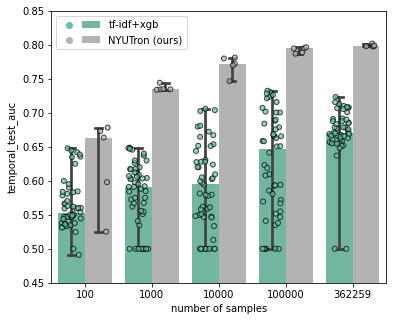

In [9]:
import numpy as np
from matplotlib.legend_handler import HandlerTuple

np.random.seed(42)
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=plot_df,
    x="n_samples",
    y="temporal_test_auc",
    hue="model",
    capsize=0.1,
    palette=[palette[0], palette[7], palette[3]],
    estimator=np.median,
    errorbar=lambda x: (x.min(), x.max()),
)
sns.stripplot(
    data=plot_df,
    x="n_samples",
    y="temporal_test_auc",
    hue="model",
    dodge=True,
    alpha=0.7,
    palette=[palette[0], palette[7]],
    ax=ax,
    s=5,
    jitter=0.3,
    linewidth=1,
    edgecolor="black",
)
plt.ylim([0.45, 0.85])
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=[(handles[idx], handles[idx + 2]) for idx in range(2)],
    labels=labels[:2],
    loc="upper left",
    handlelength=4,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)
plt.xlabel("number of samples")
plt.savefig("plots/tfidf_vs_lace_vs_ours.png", dpi=300)
plt.savefig("../AIP_plots/ext_5a.png", dpi=300)